### The primary point of this notebook is to convert the 2-minute photometry to SQLite.
It takes a few minutes to generate the database, but it makes later queries ~1000x faster!
#### The secondary point of this notebook is to explain the structure and nature of the data.

#### Setup and housekeeping...

In [1]:
%pylab
%matplotlib inline
from matplotlib import animation
from IPython.display import HTML # requires ffmpeg

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


In [2]:
import sqlalchemy as sql
import pandas as pd
import os

In [3]:
import photutils

In [4]:
from gPhoton.MCUtils import angularSeparation, print_inline
from gPhoton.galextools import counts2mag, mag2counts, aper2deg
from gPhoton import PhotonPipe, gAperture
import gfcat_utils as gfu

In [5]:
photdir = '../photom' # Relative path to the local disk location of the photometry data
data_directory='../data' # Relative path to the local disk location that data should be written
band = 'NUV' # NUV has ~10x high countrates than FUV for most types of sources

#### Use GJ65 (aka UV Ceti) as the test source.

In [6]:
skypos = (24.76279, -17.94948) # position of UV Ceti
match_radius = 0.005
eclipse = 13656 # This is one of the UV Ceti eclipses w/ a flare

#### Analyze a test visit (e26980).
To understand the structure of the data.

In [7]:
photfile = f'{photdir}/e{eclipse}/e{eclipse}-nd-photom.csv' # This is one of the UV Ceti eclipses
fn = photfile.split('/')[-1]
exptfile = f'{photdir}/e{eclipse}/e{eclipse}-nd-exptime.csv'
phot = pd.read_csv(photfile)
expt = pd.read_csv(exptfile)
total_expt = expt.expt.sum()
print(f'Eclipse {eclipse} summary:')
print(f'   * {round(total_expt)} seconds of exposure')
print(f'   * {len(phot)} unique sources detected')
print(f'   * {len(phot.loc[phot.aperture_sum_mask==0])} unflagged sources')

Eclipse 13656 summary:
   * 1530 seconds of exposure
   * 1652 unique sources detected
   * 1558 unflagged sources


#### Demonstrate that the flagging is meaningful

RA range  ==> [24.06, 25.36]
Dec range ==> [-18.57, -17.32]


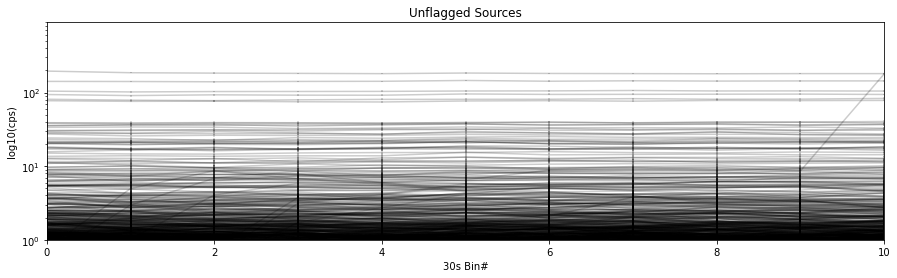

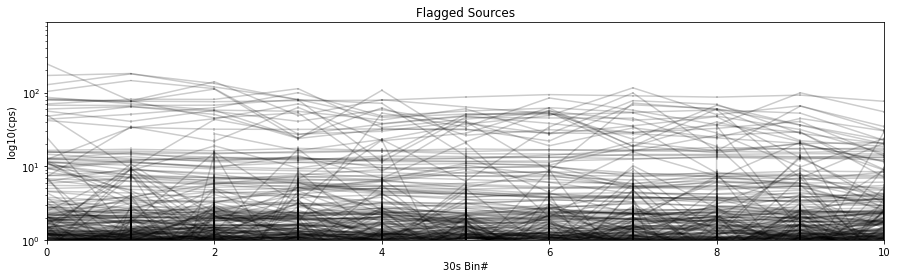

In [8]:
plt.figure(figsize=(15,4))
plt.title('Unflagged Sources')
for index in phot.index.values:
    if ((phot.loc[index].aperture_sum_mask!=0) |
        (phot.loc[index].aperture_sum_edge!=0)):
        continue
    cnt = phot.loc[index][
            ["aperture_sum_{i}".format(i=i) for i in np.arange(len(expt))]
        ].values
    cps = cnt / expt.expt.values.flatten()
    cps_err = np.sqrt(cnt) / expt.expt.values.flatten()
    plt.errorbar(np.arange(len(expt)),cps,yerr=cps_err*3,fmt='k-',alpha=0.2)
plt.semilogy()
plt.xlabel('30s Bin#')
plt.ylabel('log10(cps)')
plt.xlim([0,10])
plt.ylim([1,900])

plt.figure(figsize=(15,4))
plt.title('Flagged Sources')
for index in phot.index.values:
    if not ((phot.loc[index].aperture_sum_mask!=0) |
        (phot.loc[index].aperture_sum_edge!=0)):
        continue
    cnt = phot.loc[index][
            ["aperture_sum_{i}".format(i=i) for i in np.arange(len(expt))]
        ].values
    cps = cnt / expt.expt.values.flatten()
    cps_err = np.sqrt(cnt) / expt.expt.values.flatten()
    plt.errorbar(np.arange(len(expt)),cps,yerr=cps_err*3,fmt='k-',alpha=0.2)
plt.semilogy()
plt.xlabel('30s Bin#')
plt.ylabel('log10(cps)')
plt.xlim([0,10])
plt.ylim([1,900])

print(f"RA range  ==> [{np.round(phot.ra.min(),2)}, {np.round(phot.ra.max(),2)}]")
print(f"Dec range ==> [{np.round(phot.dec.min(),2)}, {np.round(phot.dec.max(),2)}]")

#### Dump the source position into an SQLite database.
This provides a >1000x speed up over using Dask.

In [9]:
def populate_sqlite(regen=False,catdbfile = 'catalog.db',photdir = '../photom'):
    if os.path.exists(catdbfile) and not regen:
        print(f'{catdbfile} already exists.')
        return
    if os.path.exists(catdbfile) and regen:
        os.remove(catdbfile)
    engine = sql.create_engine(f'sqlite:///{catdbfile}', echo=False)
    n_sources = 0
    for i,edir in enumerate(os.listdir(photdir)):
        if 'DS_Store' in edir: # Skip the annoying OSX cruft
            continue
        for csvfile in os.listdir(f'{photdir}/{edir}/'):
            if 'nd-photom' in csvfile:
                photpath = f'{photdir}/{edir}/{csvfile}'
                expt = pd.read_csv(photpath.replace('-photom','-exptime'))
                total_exptime = expt.expt.sum()
                eclipse = int(csvfile.split('-')[0][1:])
                photpath = f'{photdir}/{edir}/{csvfile}'
                phot = pd.read_csv(photpath)
                #print(total_exptime,phot.aperture_sum.values)
                n_sources += len(phot)
                phot['eclipse'] = eclipse
                pos = phot[['eclipse', 'id', 'ra', 'dec', 'xcenter', 'ycenter']]
                pos['exptime'] = total_exptime
                pos['cps'] = np.array(phot.aperture_sum.values)/total_exptime
                pos['cps_err'] = np.sqrt(phot.aperture_sum.values)/total_exptime
                pos['hasmask'] = phot.aperture_sum_mask.values!=0
                pos['hasedge'] = phot.aperture_sum_edge.values!=0
                #pos.to_csv(photpath.replace('-photom','-pos'),index=False)
                pos.to_sql('gfcat', con=engine, if_exists='append' if i!=0 else 'replace')
        if not i%100:
            print_inline(f'Ingesting: {i}')
    # Index on RA, Dec --- this is what we're most interested in searching against
    engine.execute("CREATE INDEX 'ix_gfcat' ON 'gfcat' ('ra', 'dec')")
    engine.dispose()
    print_inline('Source position data dumped to SQLite.\n')
    return

%time populate_sqlite()

catalog.db already exists.
CPU times: user 113 µs, sys: 103 µs, total: 216 µs
Wall time: 152 µs


In [10]:
# Test that the database is complete.
def gfcat_count(catdbfile='catalog.db'):
    engine = sql.create_engine(f'sqlite:///{catdbfile}', echo=False)
    out = engine.execute(f"SELECT COUNT(eclipse) FROM gfcat ").fetchall()
    engine.dispose()
    return out[0][0]

%time assert(gfcat_count()==18340721) # This is how many sources should be in the database

CPU times: user 766 ms, sys: 295 ms, total: 1.06 s
Wall time: 1.06 s


#### Implement a cone search

In [11]:
def query(query,catdbfile='catalog.db'):
    # This will just run any SQL query that you feed it
    engine = sql.create_engine(f'sqlite:///{catdbfile}', echo=False)
    out = engine.execute(query).fetchall()
    engine.dispose()
    return out

%time brightstars = query(f"SELECT eclipse, id FROM gfcat WHERE hasmask=0 AND hasedge=0 AND cps>622") # 2x the 10% rolloff
print(f'There are {len(brightstars)} very bright stars.\n')

CPU times: user 1.46 s, sys: 284 ms, total: 1.74 s
Wall time: 1.74 s
There are 2795 very bright stars.



In [12]:
def conesearch(skypos,match_radius=0.005,catdbfile='catalog.db'):
    # This runs a box search in SQLite and then refines it into a cone
    out = np.array(query(f"SELECT eclipse, id, ra, dec, xcenter, ycenter FROM gfcat WHERE ra >= {skypos[0]-match_radius} AND ra <={skypos[0]+match_radius} AND dec>= {skypos[1]-match_radius} AND dec<={skypos[1]+match_radius}"))
    dist_ix = np.where(angularSeparation(skypos[0],skypos[1],
                                         out[:,2],out[:,3])<=match_radius)
    return pd.DataFrame({'eclipse':np.array(out[:,0][dist_ix],dtype='int16'),
                         'id':np.array(out[:,1][dist_ix],dtype='int16'),
                         'ra':out[:,2][dist_ix],
                         'dec':out[:,3][dist_ix],
                         'xcenter':out[:,4][dist_ix],
                         'ycenter':out[:,5][dist_ix]})

%time uvceti = conesearch((24.76279, -17.94948)) # UV Ceti
print(f'There are {len(uvceti)} UV Ceti observations.')

CPU times: user 3.1 ms, sys: 1.61 ms, total: 4.71 ms
Wall time: 3.55 ms
There are 9 UV Ceti observations.


#### Define functions to get and plot lightcurves given a source position

In [24]:
def get_lightcurves(skypos,match_radius=0.005,debug=False,catdbfile='catalog.db'):
    engine = sql.create_engine(f'sqlite:///{catdbfile}', echo=False)
    out = np.array(engine.execute(f"SELECT eclipse, id, ra, dec FROM gfcat WHERE ra >= {skypos[0]-match_radius} AND ra <={skypos[0]+match_radius} AND dec>= {skypos[1]-match_radius} AND dec<={skypos[1]+match_radius}").fetchall())
    engine.dispose()
    pos = pd.DataFrame({'eclipse':out[:,0],'id':out[:,1],
                        'ra':out[:,2],'dec':out[:,3]})
    pos['dist'] = angularSeparation(skypos[0],skypos[1],pos.ra.values,pos.dec.values)
    if debug:
        plt.figure(figsize=(5,5))
        plt.title(f'{len(pos)} sources found')
        plt.plot(pos.ra,pos.dec,'k.',alpha=0.7)
        plt.plot(skypos[0],skypos[1],'rx')
        plt.xlim([skypos[0]-max(pos.dist.values)*1.1,skypos[0]+max(pos.dist.values)*1.1])
        plt.ylim([skypos[1]-max(pos.dist.values)*1.1,skypos[1]+max(pos.dist.values)*1.1])
        plt.xticks([])
        plt.yticks([])
    data = {}
    total_expt = 0
    for j in np.arange(len(pos)):
        eclipse = int(pos.iloc[j].eclipse)
        photfile = f'{photdir}/e{eclipse}/e{eclipse}-nd-photom.csv'
        exptfile = f'{photdir}/e{eclipse}/e{eclipse}-nd-exptime.csv'
        phot = pd.read_csv(photfile)
        expt = pd.read_csv(exptfile)
        total_expt += expt.expt.sum()
        cnt = phot.iloc[j][
                ["aperture_sum_{i}".format(i=i) for i in np.arange(len(expt))]
            ].values
        cps = cnt / expt.expt.values.flatten()
        cps_err = np.sqrt(cnt) / expt.expt.values.flatten()
        if debug:
            plt.figure(figsize=(15,3))
            plt.title(f'{j} : e{eclipse} : {int(pos.iloc[j].id)} : {pos.iloc[j].dist}')
            plt.errorbar(np.arange(len(expt)),cps,yerr=cps_err*3,fmt='k-',alpha=0.2)
            plt.ylabel('cps')
            plt.xticks([])
        data[j] = {'eclipse':eclipse,
                   'id':pos.iloc[j].id,
                   't0':expt.t0.min(),
                   't1':expt.t1.max(),
                   'photfile':photfile, # filepath
                   'exptfile':exptfile, # filepath
                   'photdata':phot.loc[phot.id==pos.iloc[j].id], # only photometry for source of interest
                   'exptdata':expt,
                   'counts':cnt,
                   'cps':cps,
                   'cps_err':cps_err}
    print(f'Returning {int(total_expt)} seconds of exposure.')
    return data

%time data = get_lightcurves((24.76279, -17.94948))
print(f'\nEach visit has an index (n={len(data.keys())}):\n{data.keys()}')
print(f'\nVisit #0:\n{data[0].keys()}')
print(f'\teclipse: e{(eclipse:=data[0]["eclipse"])}')
print(f'\tsource#: {(sid:=int(data[0]["id"]))}')
print(f'\nPhotometry #0:\n{data[0]["photdata"].keys()}')
print(f'\nWe will need the pixel coordinates for later: ({(x:=int(data[0]["photdata"].xcenter))}, {(y:=int(data[0]["photdata"].ycenter))})')
print(f'\nWe also need the time range for later: [{(t0:=data[0]["t0"])}, {(t1:=data[0]["t1"])}]')

# WARNING: Pandas indexes starting at 1 whereas numpy (and computer scientists) index starting at 0.
#          So do not try to index with "id" using Pandas `iloc` because it will be wrong.

Returning 13520 seconds of exposure.
CPU times: user 149 ms, sys: 14.4 ms, total: 164 ms
Wall time: 170 ms

Each visit has an index (n=9):
dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8])

Visit #0:
dict_keys(['eclipse', 'id', 't0', 't1', 'photfile', 'exptfile', 'photdata', 'exptdata', 'counts', 'cps', 'cps_err'])
	eclipse: e13656
	source#: 804

Photometry #0:
Index(['id', 'xcentroid', 'ycentroid', 'sharpness', 'roundness1', 'roundness2',
       'npix', 'sky', 'peak', 'flux', 'mag', 'xcenter', 'ycenter',
       'aperture_sum', 'aperture_sum_mask', 'aperture_sum_edge', 'ra', 'dec',
       'aperture_sum_0', 'aperture_sum_1', 'aperture_sum_2', 'aperture_sum_3',
       'aperture_sum_4', 'aperture_sum_5', 'aperture_sum_6', 'aperture_sum_7',
       'aperture_sum_8', 'aperture_sum_9', 'aperture_sum_10',
       'aperture_sum_11', 'aperture_sum_12', 'aperture_sum_13',
       'aperture_sum_14'],
      dtype='object')

We will need the pixel coordinates for later: (1475, 1647)

We also need the time range 

#### Define functions to return photometry data given an eclipse / source id

CPU times: user 20.7 ms, sys: 3.67 ms, total: 24.4 ms
Wall time: 23.3 ms


([], [])

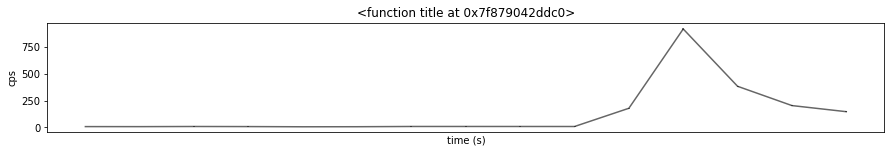

In [17]:
def get_lightcurve(eclipse,sid,photdir = '../photom'):
    # given an eclipse and source id, return the lightcurve data
    phot = pd.read_csv(f'{photdir}/e{eclipse}/e{eclipse}-nd-photom.csv')
    expt = pd.read_csv(f'{photdir}/e{eclipse}/e{eclipse}-nd-exptime.csv')
    total_expt = expt.expt.sum()
    cnt = np.array([phot.loc[phot.id==sid][f"aperture_sum_{i}"].values[0] for i in np.arange(len(expt))])
    exptimes = expt.expt.values,
    cps = cnt / exptimes
    cps_err = np.sqrt(cnt) / exptimes
    return pd.DataFrame({'t0':expt.t0,'t1':expt.t1,
                         'expt':exptimes[0],'counts':cnt,
                         'cps':(cnt / exptimes[0]),
                         'cps_err':(np.sqrt(cnt) / exptimes[0])})

%time lc120 = get_lightcurve(eclipse,sid,photdir=photdir)
plt.figure(figsize=(15,2))
plt.title(title if title else f'e{eclipse} : {sid}')
plt.errorbar(np.array(lc120['t0'])-min(lc120['t0']),lc120['cps'],yerr=lc120['cps_err']*3,fmt='k-',alpha=0.6)
plt.xlabel('time (s)')
plt.ylabel('cps')
plt.xticks([])

#### Generate gPhoton lightcurves of the target

In [26]:
lc010 = gAperture(band,skypos,aper2deg(6),trange=[t0,t1],stepsz=10,verbose=2) # can take tens of minutes

Using v1.28.9_HDF5 of gAperture.
Generating a light curve with the following paramters:
 band:    NUV
 skypos:  (24.76279, -17.94948)
 tranges: [816379178.995, 816380978.995]
 radius:  0.0035555555555555557
 annulus: None
 stepsz:  10
 csvfile: None
 verbose: 2
                                                            24.76279, -17.94948]AB Magnitudes:               
[17.63777317 18.34515865 18.00342648 17.68629345 18.06412005 18.3446621
 17.68318258 17.58848918 17.8930381  17.6914897  17.5681953  17.76427774
 17.92694478 17.93174272 17.77665744 17.70045486 17.98703876 17.79349555
 17.93121925 17.9223205  18.02909443 17.94943845 17.8322557  17.80856708
 18.18189149 18.39388418 18.00666144 17.94419941 17.99574038 18.15482693
 16.73488073 17.67519848 17.70569486 17.51607371 17.74421422 17.45763091
 17.85501136 17.509496   17.88775538 17.69048506 17.84433659 17.90758329
 17.90532742 18.08330307 17.89849317 17.78485663 17.9760262  17.85398721
 17.94320982 18.16250381 17.93771922 18.13809

([], [])

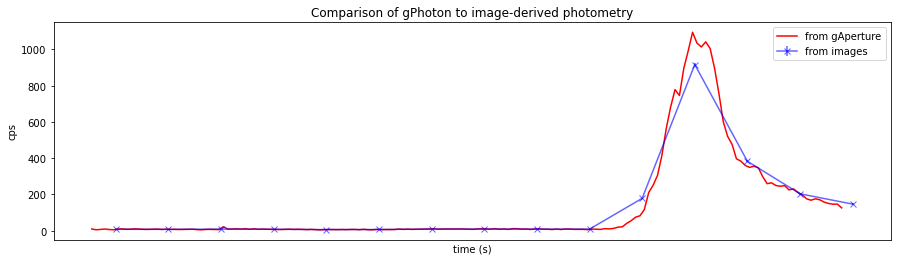

In [41]:
plt.figure(figsize=(15,4))
plt.title('Comparison of gPhoton to image-derived photometry')
plt.errorbar(np.array(lc120['t0'])+60,lc120['cps'],yerr=lc120['cps_err']*3,fmt='bx-',alpha=0.6,label='from images')
plt.plot(lc010['t0']+5,lc010['cps'],'r-',label='from gAperture')
plt.legend()
plt.xlabel('time (s)')
plt.ylabel('cps')
plt.xticks([])

## Generate QA Images & Movies

#### Download the raw data from MAST

In [ ]:
raw6file = gfu.download_raw6(eclipse,band,data_directory=data_directory)

#### Calibrate the data

In [ ]:
photonfile = '{d}/e{e}/e{e}-{b}d.h5'.format(
        d=data_directory, e=eclipse, b='n' if band=='NUV' else 'f') # output filename
print(f'Photon data file: {photonfile}')
if not os.path.exists(photonfile):
    PhotonPipe.photonpipe(raw6file[:-13],band,raw6file=raw6file,verbose=2)
else:
    print('\tAlready exists.')

In [ ]:
xcalfilename = photonfile.replace('.h5','-xcal.h5')
print(f'E[x]tended photon data file: {xcalfilename}')
if not os.path.exists(xcalfilename):
    events = gfu.calibrate_photons(photonfile,band)
    if len(events):
        print('Writing {xcalfilename}'.format(xcalfilename=xcalfilename))
        os.remove(xcalfilename) # Warning re: append. Important that file doesn't already exist!
        with pd.HDFStore(xcalfilename) as store:
            store.append('events',events)
    else:
        raise('There is no valid data in this visit and everything after will fail.')
else:
    print('\tAlready exists.')

#### Create full-depth images and 120s movies
This is the biggest processing bottleneck. It will hit CPU and memory hard, and little has been done to mitigate that. 32Gb of onboard memory is recommended as a minimum. For unusually bright fields, 128Gb is probably needed.

In [ ]:
cntfilename = photonfile.replace(".h5", "-cnt.fits.gz")
movfilename = photonfile.replace(".h5", "-mov.fits.gz")
print(f'Image file: {cntfilename}')
print(f'Movie file: {movfilename}')
# This is the biggest processing bottleneck... will hit CPU and memory hard!
if not os.path.exists(cntfilename) or not os.path.exists(movfilename):
    %time gfu.make_images(eclipse,band,data_directory=data_directory,bins=["",120])
#Useful tip:          This number defines the movie frame duration in seconds.^^^
#                     So setting it to 30 would produce 30-second movies, etc.^^^
else:
    print('\tAlready exist.')

#### The images are structured as follows:
1. Full depth images have "cnt" in the filename (in reference to the mission-produced "count" maps).
    * These have been corrected for detector response, but not exposure time.
    * The calibrated (aka "effective") exposure time appears in the header. So divide the image by this to get the "intensity" map.
    * There are two backplane images.
        1. One is an image of all of the events covered by the hotspot mask.
        2. Another is an image of all of the events >400 "flat pixels" from the center of the detector. (in arcsecs?)
    * The "edge" and "mask" flags are generated by running aperture photometry identically on the backplanes as on the main image. Any amount of edge of mask "flux" within the aperture sets the flag as True.
2. Movie files have "mov" in the filename.
    * The time ranges and effective exposure times for each frame appear in header keywords with the frame index as a suffix, e.g. `EXPTIME_1` for the exposure time of the first frame.
    
Count and movie files are created with identical World Coordinate System (WCS) information. The intention intention is that source _detection_ occur on the full-depth images and then source _measurement_ can occur identically on all of the movie frames.
    
The following convenience functio---`read_image()`---will parse the useful information out of these files.

In [ ]:
cntmap, flagmap, edgemap, wcs, trange, exptime = gfu.read_image(cntfilename)
plt.figure(figsize=(15, 15))
plt.title('Full-frame, full-depth')
plt.imshow(np.zeros(np.shape(cntmap)),cmap="Greys_r")
plt.imshow(np.log10(cntmap), cmap="Greys", origin="lower")
plt.imshow(np.log10(edgemap), origin="lower", cmap="cool") # "edge" events are blueish
plt.imshow(np.log10(flagmap), origin="lower", cmap="Wistia") # "hotspot" events are yellowish
plt.xticks([])
plt.yticks([])
plt.tight_layout()

print(f'Time range: {trange}\n')
print(f'Exposure time: {exptime}\n')
print(f'{wcs}')

In [ ]:
# This generates an animated movie of the scene and can take a few minutes...
# But it's worth it. The end result is really neat.
movmap, _, _, wcs, tranges, exptimes = gfu.read_image(movfilename)
    
print(f'\n{len(movmap)} images frames.\n')
print(f'Time ranges: {tranges}\n')
print(f'Exposure times: {exptimes}\n')
print(f'{wcs}')

# Create an animated image
fig = plt.figure(figsize=(15,15))
plt.title('Full-frame movie')
plt.xticks([])
plt.yticks([])
plt.tight_layout()

ims = []
for i,frame in enumerate(movmap[:-1]): # eliminate the last frame, which always has lower exposure
    ims.append([
        plt.imshow(np.zeros(np.shape(frame)),cmap="Greys_r", animated=True),
        plt.imshow(np.log10(frame/exptimes[i]), cmap="Greys", origin="lower", animated=True),
        plt.imshow(np.log10(edgemap), origin="lower", cmap="cool", animated=True),
        plt.imshow(np.log10(flagmap), origin="lower", cmap="Wistia", animated=True),
    ])
    
ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat=True)

HTML(ani.to_html5_video())
#HTML(ani.to_jshtml()) # for an interactive animation

#NOTE: I don't know why this is displaying a duplicate image under the movie or how to make it stop doing that.

#### Generate an image stamp of the target source

In [ ]:
sz = 100 # half height / width of stamp in pixels
x,y = (1475, 1647) # pixel (xcenter, ycenter) copied from previous notebook
plt.figure(figsize=(20, 20))
plt.imshow(np.log10(cntmap[y - sz : y + sz, x - sz : x + sz]),origin='lower',cmap='Greys_r')
plt.imshow(np.log10(edgemap[y - sz : y + sz, x - sz : x + sz]),origin='lower',cmap='cool')
plt.imshow(np.log10(flagmap[y - sz : y + sz, x - sz : x + sz]),origin='lower',cmap='Wistia')
# Now overplot the aperture
photutils.CircularAperture([sz,sz], r=8.533333333333326).plot(color='red', lw=2, alpha=1)
plt.xticks([])
plt.yticks([])

#### And generate an movie stamp. Why not? It's the future.

In [ ]:
fig = plt.figure(figsize=(15,15))
plt.title("It's a flare, y'all!")
plt.xticks([])
plt.yticks([])

sz = 100 # half height / width of stamp in pixels
x,y = (1475, 1647) # pixel (xcenter, ycenter) copied from previous notebook

ims = []
for i,frame in enumerate(movmap[:-1]):
    ims.append([
        plt.imshow(np.log10(frame[y - sz : y + sz, x - sz : x + sz]/exptimes[i]),origin='lower',cmap='Greys_r', animated=True),
        plt.imshow(np.log10(edgemap[y - sz : y + sz, x - sz : x + sz]),origin='lower',cmap='cool', animated=True),
        plt.imshow(np.log10(flagmap[y - sz : y + sz, x - sz : x + sz]),origin='lower',cmap='Wistia', animated=True),
        #photutils.CircularAperture([sz,sz], r=8.533333333333326).plot(color='red', lw=2, alpha=1),
    ])
    
ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat=True)

HTML(ani.to_html5_video())
#HTML(ani.to_jshtml())

#NOTE: I don't know why this is displaying an image under the movie or how to make it stop.